In [1]:
# pip install qiskit==0.31.0

In [201]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit import BasicAer, execute
from tqdm import tqdm
import numpy as np
backend = BasicAer.get_backend("qasm_simulator")

def qft(num_qubits,is_inverse):
    qft_gate = QFT(num_qubits=num_qubits, do_swaps=False, inverse=is_inverse).to_gate()
    return qft_gate
def subroutine_add_const(num_qubits,const):
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        angle = const*np.pi/(2**i)
        qc.p(angle,i)
    return qc.to_gate()

In [124]:
qft_circuits=[]
for i in range(1,8):
    qft_gate = qft(num_qubits=i,is_inverse=False)
    for j in range(8-i):
        qr = QuantumRegister(7)
        cr = ClassicalRegister(7)
        qc = QuantumCircuit(qr,cr)
        qc.append(qft_gate, qr[j:j+i])
        qc.measure(qr,cr)
        qft_circuits.append(qc)
# qft_circuits[0].draw(output='mpl')

In [125]:
addition_circuits = []
with tqdm(total=10795) as pbar:
    for bits in range(1,8):
        max_num = 2**bits
        for i in range(max_num):
            for j in range(1,max_num):
                if i+j < max_num:
                    qr = QuantumRegister(7)
                    cr = ClassicalRegister(7)
                    qc = QuantumCircuit(qr,cr)
                    qft_gate = qft(num_qubits=bits,is_inverse=False)
                    qc.append(qft_gate, qr[:bits])

                    qc.append(subroutine_add_const(bits,i), qr[:bits])
                    qc.append(subroutine_add_const(bits,j), qr[:bits])

                    inverse_qft_gate = qft(num_qubits=bits,is_inverse=True)
                    qc.append(inverse_qft_gate, qr[:bits])
                    qc.measure(qr,cr)

                    # counts = execute(qc,backend,shots=100).result().get_counts()
                    # bin_val = int(list(counts.keys())[0],2)
                    pbar.update(1)
                    addition_circuits.append(qc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10795/10795 [00:54<00:00, 199.90it/s]


In [126]:
def ghz_recursive(qc, quantum_register, low, mid, high):
    if low<mid and mid<high and low>=0 and mid>=0 and high>=0:
        # print(low, (low+mid)//2, mid, (mid+high+1)//2) 
        if low< (low+mid)//2:
            qc.cnot(quantum_register[low], quantum_register[(low+mid)//2])
        if mid < (mid+high+1)//2:
            qc.cnot(quantum_register[mid], quantum_register[(mid+high+1)//2])
        ghz_recursive(qc, quantum_register, low, (low+mid)//2, mid-1)
        ghz_recursive(qc, quantum_register, mid, (mid+high+1)//2, high)
def generate_ghz_logn(n):
    quantum_register = QuantumRegister(n)
    qc = QuantumCircuit(quantum_register)

    ####### your code goes here #######
    qc.h(quantum_register[0])
    qc.cnot(quantum_register[0], quantum_register[n//2])
    ghz_recursive(qc, quantum_register, 0, n//2, n-1)

    return qc.to_gate()


ghz_rec_circuits=[]
for i in range(2,8):
    ghz_circuit = generate_ghz_logn(i)
    for j in range(8-i):
        qr = QuantumRegister(7)
        cr = ClassicalRegister(7)
        qc = QuantumCircuit(qr,cr)
        qc.append(ghz_circuit, qr[j:j+i])
        qc.measure(qr,cr)
        ghz_rec_circuits.append(qc)
# qft_circuits[0].draw(output='mpl')

In [127]:
def generate_ghz(n):
    quantum_register = QuantumRegister(n)
    qc = QuantumCircuit(quantum_register)

    ####### your code goes here #######
    qc.h(quantum_register[0])
    for i in range(1,n):
        qc.cnot(quantum_register[0], quantum_register[i])
    return qc.to_gate()


ghz_circuits=[]
for i in range(2,8):
    ghz_circuit = generate_ghz(i)
    for j in range(8-i):
        qr = QuantumRegister(7)
        cr = ClassicalRegister(7)
        qc = QuantumCircuit(qr,cr)
        qc.append(ghz_circuit, qr[j:j+i])
        qc.measure(qr,cr)
        ghz_circuits.append(qc)

In [187]:
def oracle_func(qc,database,oracle,num_to_find):
    bin_to_find = (bin(num_to_find)[2:]).rjust(len(database),'0')
    
    bin_to_find = bin_to_find[::-1]
    for i in range(len(bin_to_find)):
        if bin_to_find[i] == '0':
            qc.x(database[i])
    qc.mct(database[:], oracle[0]) 
    for i in range(len(bin_to_find)):
        if bin_to_find[i] == '0':
            qc.x(database[i])
def grover_circuit(num_qubits, num_iteration, num_to_find):
    database = QuantumRegister(num_qubits-1)
    oracle = QuantumRegister(1)
    qc = QuantumCircuit(database,oracle)
    
    # initialization
    qc.h(database[:])
    qc.x(oracle[0])
    qc.h(oracle[0])
    
    # iters
    for j in range(num_iteration):
        # oracle
        oracle_func(qc,database,oracle,num_to_find)

        # diffusion
        qc.h(database[:])
        qc.x(database[:])
        qc.h(database[-1])
        qc.mct(database[0:-1], database[-1])
        qc.h(database[-1])
        qc.x(database[:])
        qc.h(database[:])
    qc.h(oracle[0])
    qc.x(oracle[0])
    return qc.to_gate()

In [218]:
grover_circuits=[]
with tqdm(total=868) as pbar:
    for bits in range(3,8):
        max_num = 2**(bits-1)
        iterations = int(np.floor((np.pi/4)*np.sqrt(max_num)))
        for itrs in range(1,iterations+1):
            for num_to_find in range(max_num):
                grover_gate = grover_circuit(num_qubits=bits, num_iteration=itrs, num_to_find=num_to_find)
                for j in range(8-bits):
                    qr = QuantumRegister(7)
                    cr = ClassicalRegister(7)
                    qc = QuantumCircuit(qr,cr)
                    qc.append(grover_gate, qr[j:j+bits])
                    qc.measure(qr,cr)
                    grover_circuits.append(qc)
                    pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 868/868 [00:01<00:00, 704.76it/s]


In [219]:
len(grover_circuits)

868

In [284]:
from qiskit.circuit.library import PhaseEstimation

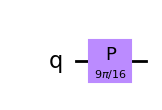

In [313]:
U = QuantumCircuit(1)
U.p(9*np.pi/16,0)
U.draw(output='mpl')

In [324]:
def get_unitary(bits_for_unitary,phase):
    qc = QuantumCircuit(bits_for_unitary)
    qc.p(phase,0)
    return qc
def get_qpe(num_qubits, phase, bits_for_unitary):
    U = get_unitary(bits_for_unitary,phase)
    iqft = QFT(num_qubits=num_qubits, do_swaps=False, inverse=True)
    QPE = PhaseEstimation(num_evaluation_qubits=num_qubits, unitary=U, iqft=iqft)
    return QPE

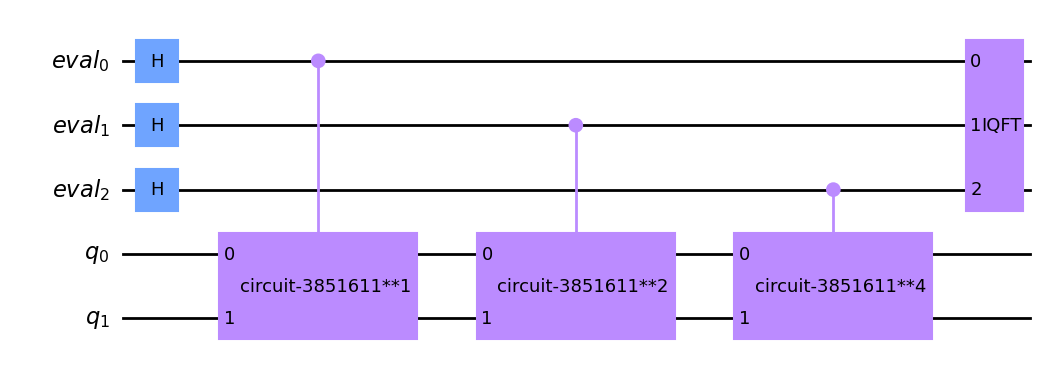

In [326]:
qpe = get_qpe(3, 7*np.pi/4, 2)
qpe.decompose().draw(output='mpl')

In [371]:
def get_qpe_circuits_for_phase(phase):
    circ_list = []
    for eval_bits in range(3,8):
        for unitary_bits in range(1, 7-eval_bits+1):
            circ_size = eval_bits+unitary_bits
            qpe = get_qpe(eval_bits, phase, unitary_bits)
            for j in range(circ_size,8):
                qr = QuantumRegister(7)
                cr = ClassicalRegister(eval_bits)
                qc = QuantumCircuit(qr,cr)
                for eig_bits in range(j-1,j-1-unitary_bits,-1):
                    qc.x(qr[eig_bits])
                qc.append(qpe, qr[j-circ_size:j])
                qc.measure(qr[:eval_bits],cr)
                circ_list.append(qc)
    return circ_list
phases = [(np.random.randint(1,64))/64 for _ in range(20)]
qpe_circuits = []
for p in phases:
    qpe_circuits= qpe_circuits+get_qpe_circuits_for_phase(p)